# BERT notebook

In [1]:
!pip install -q gdown

In [2]:
import gdown
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

In [3]:
gdown.download("https://drive.google.com/u/0/uc?export=download&confirm=znhq&id=1RHS3GdZNM9yz89GNWYycc3V94ezI3JzC", "request.gz", True)

'request.gz'

In [4]:
!gunzip request.gz

### Data preprocessing

In [106]:
data = pd.read_json("/content/request", lines=True)

In [107]:
data.head(7)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,NaN,NaN
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,NaN,NaN
2,1,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,1523836800,NaN,NaN
3,3,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,1523577600,NaN,NaN
4,5,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,NaN,NaN
5,5,True,"03 24, 2018",AIY18YON1TWJJ,0209688726,{'Color:': ' Black'},Karen H.,Have 3 big dogs. this have been great for my F...,this have been great for my Ford transit connect,1521849600,NaN,NaN
6,3,True,"03 4, 2018",A2MPTQ85HBBNG2,0209688726,{'Color:': ' Black'},Giv,"Pros: Good attachments, nice long cord, can re...",Decent car vaccuum.,1520121600,NaN,NaN


In [7]:
data = data[["overall", "reviewText"]]

Check for NaN values

In [8]:
data.isna().any()

overall       False
reviewText     True
dtype: bool

In [9]:
print("Amount of samples BEFORE dropping empty values: ", data.shape[0])
print("Amount of samples AFTER dropping empty values: ", data.dropna().shape[0])
print("Amount of dropped lines: ", data.shape[0] - data.dropna().shape[0])

Amount of samples BEFORE dropping empty values:  1000000
Amount of samples AFTER dropping empty values:  999636
Amount of dropped lines:  364


Delete missed values and reset index

In [10]:
data.dropna(inplace=True)

In [11]:
data.reset_index(drop=True, inplace=True)

In [12]:
data.describe()

,overall
count,999636.000000
mean,4.480915
std,1.022296
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [13]:
rate_distr = dict(data.value_counts("overall"))

As we see, there is disbalance in our data

[Text(0, 0.5, 'Feedbacks amount'), Text(0.5, 0, 'Rate')]

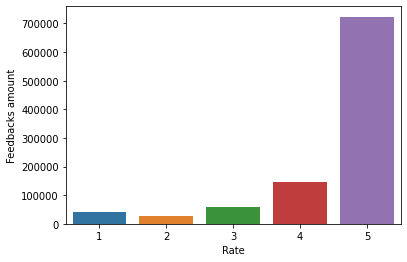

In [14]:
ax = sns.barplot(x = list(rate_distr.keys()), y = list(rate_distr.values()))
ax.set(xlabel="Rate", ylabel="Feedbacks amount")

Check the sentence lengths

In [15]:
reviewsLength = data["reviewText"].apply(lambda x: len(x.split()))

In [16]:
reviewsLength.describe()

count    999636.000000
mean         36.617947
std          58.642644
min           0.000000
25%           6.000000
50%          20.000000
75%          43.000000
max        3727.000000
Name: reviewText, dtype: float64

In [17]:
data["overall"].value_counts()

5    723709
4    145630
3     59565
1     41940
2     28792
Name: overall, dtype: int64

Decreasing the value by one for training reasons (As I have multi-class classification)

In [18]:
data["overall"] = data["overall"].apply(lambda x: x-1)

## BERT Transformer

In [19]:
!pip install -q transformers

     |████████████████████████████████| 1.8MB 8.1MB/s 
     |████████████████████████████████| 890kB 34.8MB/s 
     |████████████████████████████████| 2.9MB 45.3MB/s 


In [20]:
import transformers as ppb

In [21]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, "distilbert-base-uncased")

In [22]:
bert_model = model_class.from_pretrained(pretrained_weights)
bert_tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

In [23]:
from torch.utils.data import Dataset

class BertTokenizedDataset(Dataset):
    def __init__(self, reviews, tokenizer, labels):
        self.labels = labels
        # tokenized reviews
        self.tokenized = reviews.apply((lambda x: tokenizer.encode(x, truncation=True, max_length=70)))

    def __getitem__(self, idx):
        return {"tokenized": self.tokenized[idx], "label": self.labels[idx]}
    
    def __len__(self):
        return len(self.labels)

In [24]:
%%time
bert_dataset = BertTokenizedDataset(data.iloc[:, 1], bert_tokenizer, data.iloc[:, 0])

CPU times: user 12min 2s, sys: 313 ms, total: 12min 2s
Wall time: 12min 3s


For time saving, I was using pickle to save dataset

In [25]:
# import pickle

# with open("bert_dataset", "wb") as file:
#     pickle.dump(bert_dataset, file)

# with open("bert_dataset", "rb") as file:
#     bert_dataset = pickle.load(file)

### Data iterators creation (that part differs a little bit from RNN model part)

In [26]:
def split_data(dataset, ratios):
    lengths = [int(len(dataset) * ratio) for ratio in ratios]
    if np.sum(lengths != len(dataset)):
        lengths[-1] = len(dataset) - np.sum(lengths[:-1])

    return random_split(dataset, lengths)

In [27]:
torch.manual_seed(2) 
train_data, valid_data, test_data = split_data(bert_dataset, [0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 799708
Number of validation examples: 99963
Number of testing examples: 99965


In [28]:
from torch.utils.data import Sampler

class ReviewsSampler(Sampler):
    def __init__(self, subset, batch_size=64):
        self.batch_size = batch_size
        self.subset = subset

        self.indices = subset.indices
        # tokenized for our data
        self.tokenized = np.array(subset.dataset.tokenized)[self.indices]

    def __iter__(self):

        batch_idx = []
        # index in sorted data
        for index in np.argsort(list(map(len, self.tokenized))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.subset) // self.batch_size

In [29]:
from torch.utils.data import DataLoader

def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])
    return padded

def collate_fn(batch):

    inputs = []
    labels = []
    for elem in batch:
        inputs.append(elem['tokenized'])
        labels.append(elem['label'])

    inputs = get_padded(inputs)
    attention_mask = np.where(inputs != 0, 1, 0)

    return {"inputs": torch.tensor(inputs), "labels": torch.FloatTensor(labels), 'attention_mask' : torch.tensor(attention_mask)}

train_loader = DataLoader(train_data, batch_sampler=ReviewsSampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=ReviewsSampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=ReviewsSampler(test_data), collate_fn=collate_fn)

# Model

In [30]:
from torch import nn

class BertClassifier(nn.Module):
  def __init__(self, pretrained_model, n_classes, dropout=0.3):
    super().__init__()

    self.bert = pretrained_model
    self.drop = nn.Dropout(dropout)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0, :]

    output = self.drop(bert_output)
    return self.out(output)

In [39]:
#@title **Bert model hyperparameters** { run: "auto" }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ", device)

EPOCHS = 4 #@param {type:"slider", min:1, max:10, step:1}
OUTPUT_SIZE = 5 #equals to number of label classes 
HIDDEN_SIZES = [128, 64] #@param ["[128, 64]", "[256, 128]", "[512, 256]", "[1024, 512]", "[2048, 1024]"] {type:"raw", allow-input: true}
CLIP = 1 #@param {type:"slider", min:0, max:10, step:1}
DROPOUT = 0.3 #@param {type:"slider", min:0.1, max:0.9, step:0.1}

Device is:  cuda


I would like to again use CrossEntropyLoss`s "weight" attribute, but in that case, google colab crashes for unknown reasons.

In [32]:
bert_clf = BertClassifier(bert_model, OUTPUT_SIZE, DROPOUT).to(device)
optimizer = torch.optim.Adam(bert_clf.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

### Training


In [33]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()

    epoch_loss = 0

    all_predicts = []
    all_targets = []

    for iteration, batch in tqdm(enumerate(iterator), total=len(iterator)):
        input = batch["inputs"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"]

        logits = model(input, attention_mask)
        loss = criterion(logits.cpu(), labels.long())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.softmax(logits, 1)
        preds = torch.argmax(probs, 1)

        all_predicts = np.concatenate((all_predicts, preds.cpu().detach().numpy()))
        all_targets = np.concatenate((all_targets, labels.cpu().detach().numpy()))

    epoch_loss /= len(iterator)

    return epoch_loss, f1_score(all_targets, all_predicts, average="weighted")

In [34]:
def evaluate(model, iterator, criterion):
    model.eval()

    all_predicts = []
    all_targets = []
    
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator), total=len(iterator)):
            input = batch["inputs"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            logits = model(input, attention_mask)
            loss = criterion(logits.cpu(), labels.long())

            probs = torch.softmax(logits, 1)
            preds = torch.argmax(probs, 1)

            all_predicts = np.concatenate((all_predicts, preds.cpu().detach().numpy()))
            all_targets = np.concatenate((all_targets, labels.cpu().detach().numpy()))
            
            epoch_loss += loss.item()

        epoch_loss /= len(iterator)
        
    return epoch_loss, f1_score(all_targets, all_predicts, average="weighted")

In [35]:
MIN_LOSS = np.inf
CUR_PATIENCE = 0
PATIENCE = 2

Occasionally, I did not calculate the perplexity correctly - forgot to put the loss inside np.exp function

In [40]:
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
        
    train_loss, train_f1 = train(bert_clf, train_loader, optimizer, criterion, CLIP)
    valid_loss, valid_f1 = evaluate(bert_clf, valid_loader, criterion)
    
    if valid_loss < MIN_LOSS:
        MIN_LOSS = valid_loss
        best_model = bert_clf.state_dict()
    else:
        CUR_PATIENCE += 1
        if CUR_PATIENCE == PATIENCE:
            CUR_PATIENCE = 0
            break

    torch.save(best_model, 'best-val-bert-model.pt')

    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_loss:.3f}')
    print(f'\tTrain f1_score: {train_f1:.3f} | Valid f1_score: {valid_f1:.3f}')


	Train Loss: 0.519 | Train PPL: 0.519
	 Val. Loss: 0.566 |  Val. PPL: 0.566
	Train f1_score: 0.778 | Valid f1_score: 0.775



	Train Loss: 0.478 | Train PPL: 0.478
	 Val. Loss: 0.570 |  Val. PPL: 0.570
	Train f1_score: 0.799 | Valid f1_score: 0.777


In [42]:
print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):.3f}')
print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):.3f}')
print(f'\tTrain f1_score: {train_f1:.3f} | Valid f1_score: {valid_f1:.3f}')

	Train Loss: 0.436 | Train PPL: 1.547
	 Val. Loss: 0.590 |  Val. PPL: 1.803
	Train f1_score: 0.821 | Valid f1_score: 0.779


In [ ]:
gdown.download("https://drive.google.com/u/0/uc?export=download&confirm=RO3P&id=1dveHP-KZPWDXLCXWWntFPDlGdAIF3MAK", "bert_clf.pt", True)

In [ ]:
bert_clf = BertClassifier(bert_model, OUTPUT_SIZE, DROPOUT).to(device)
bert_clf.load_state_dict(torch.load("/content/bert_clf.pt"))

### Testing

In [46]:
def test(test_iterator, model, device):
    model.eval()

    all_predicts = []
    all_targets = []

    history = []
    
    for iteration, batch in tqdm(enumerate(test_iterator), total=len(test_iterator)):
        input = batch["inputs"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"]

        logits = model(input, attention_mask)

        probs = torch.softmax(logits, 1)
        preds = torch.argmax(probs, 1)

        all_predicts = np.concatenate((all_predicts, preds.cpu().detach().numpy()))
        all_targets = np.concatenate((all_targets, labels.cpu().detach().numpy()))
        
    print("F1 score: ", f1_score(all_targets, all_predicts, average="weighted"))

In [47]:
test(test_loader, bert_clf, device)


F1 score:  0.7779127787284364


### Predicting

In [97]:
def predict_rate(sentence):
    tokens = bert_tokenizer.encode(sentence)
    attention_mask = torch.ones(len(tokens)).unsqueeze(0).to(device)
    inputs = torch.LongTensor(tokens).unsqueeze(0).to(device)

    bert_clf.eval()
    logits = bert_clf(inputs, attention_mask)

    probs = torch.softmax(logits, 1)
    prediction = torch.argmax(probs, 1)

    return prediction.item() + 1

In [100]:
sentence = "That's fascinating!"
predict_rate(sentence)

5

In [101]:
sentence = "Difficult to say"
predict_rate(sentence)

3

In [102]:
sentence = "Don't reccomend at all"
predict_rate(sentence)

1

In [103]:
sentence = "Money waste"
predict_rate(sentence)

1

In [104]:
sentence = "I probably will buy again in that store"
predict_rate(sentence)

4